# Fetching the Dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! cp /content/drive/MyDrive/Dataset.zip Dataset.zip

In [3]:
# !unzip -q Dataset.zip -d Dataset/

### Acknowledgements
The original files are located here: https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset

# Importing Dependencies

In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Flatten, Reshape, GRU, BatchNormalization, Dense

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
)

# Visualization
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2024-07-05 16:29:44.090440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 16:29:44.090545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 16:29:44.236753: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Constants

In [5]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
CHANNELS = 3
EPOCHS = 20
PATH = '/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset/'

# Importing data into a TensorFlow dataset object

We will use the `image_dataset_from_directory` API to load all images into a TensorFlow dataset. [Link to the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)

In [6]:
dataset = image_dataset_from_directory(
    PATH + '',
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 6902 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['covid', 'normal', 'pneumonia']

# Visualizing the first batch of images.

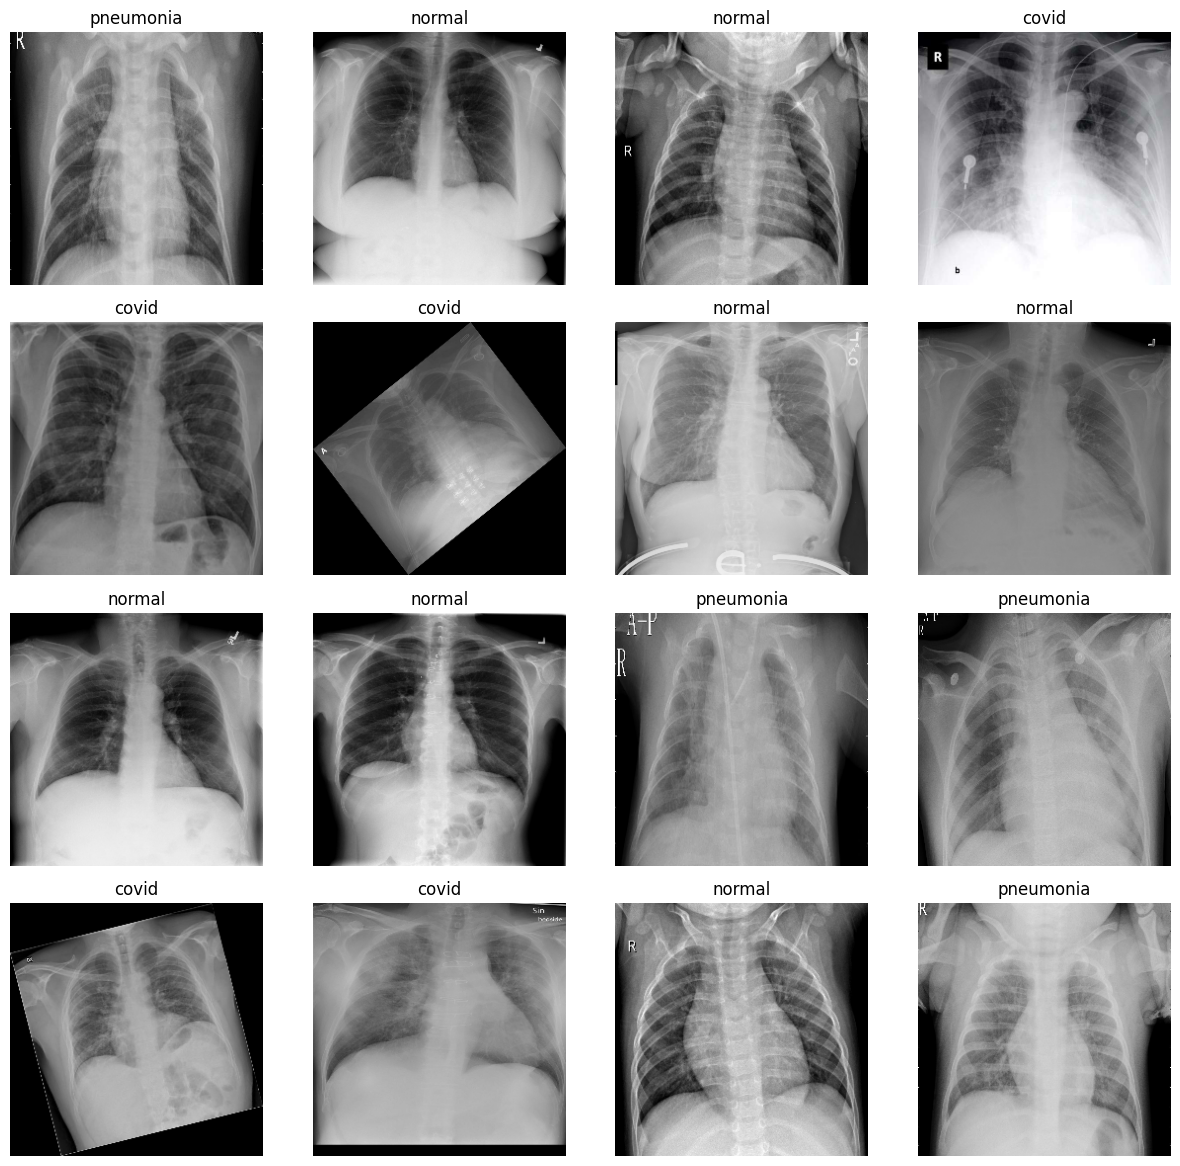

In [8]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")


# Splitting Dataset into Training, Validation, and Testing

In [9]:
TRAIN_SIZE, VALIDATION_SIZE= 0.8, 0.2

In [10]:
train_batch = int(len(dataset) * TRAIN_SIZE)
train_ds = dataset.take(train_batch)

In [11]:
val_batch = int(len(dataset) * VALIDATION_SIZE)
validation_ds = dataset.skip(train_batch).take(val_batch)

# Building Model

## Resizing and Normalization Layer

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

## Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

# ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

base_model.trainable = False

# Model
model = Sequential([
    base_model,
    Flatten(),
    Reshape((base_model.output_shape[1] * base_model.output_shape[2], base_model.output_shape[3])),
    GRU(512, activation="relu", return_sequences=True),
    BatchNormalization(),
    Flatten(),
    Dense(units=1024, activation='relu'),
    BatchNormalization(),
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dense(n_classes, activation='softmax')
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Creating a checkpoint to save the model with the best score.

In [17]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras')
]

## Training

In [18]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = validation_ds,
    verbose = 1,
    epochs = EPOCHS,
    callbacks = callback
)

Epoch 1/20


I0000 00:00:1720197041.203360      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720197041.265203      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720197041.367839      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.8071 - loss: 0.7497

W0000 00:00:1720197108.486321      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720197108.488699      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8088 - loss: 0.7425 - val_accuracy: 0.7227 - val_loss: 1.9748
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9257 - loss: 0.2132 - val_accuracy: 0.9227 - val_loss: 0.2499
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9430 - loss: 0.1798 - val_accuracy: 0.9453 - val_loss: 0.1718
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9535 - loss: 0.1442 - val_accuracy: 0.9531 - val_loss: 0.1700
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9514 - loss: 0.1442 - val_accuracy: 0.9594 - val_loss: 0.1391
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9621 - loss: 0.1168 - val_accuracy: 0.9508 - val_loss: 0.1766
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9530 - loss: 0.1281 - val_accuracy: 0.9203 - val_loss: 0.2441
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9688 - loss: 0.0981 - val_accuracy: 0.9297 - val_loss: 0.2049
Ep

## Loading Model

In [19]:
model = load_model('model.keras')

## Evaluation

### Predict

In [20]:
all_predictions = []
all_labels = []
for images, labels in validation_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(labels.numpy())

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


### Metrices

In [21]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.96171875
F1 Score:  0.9618340534917682
Recall:  0.96171875
Precision:  0.9643046664758472


### Confusion Matrix

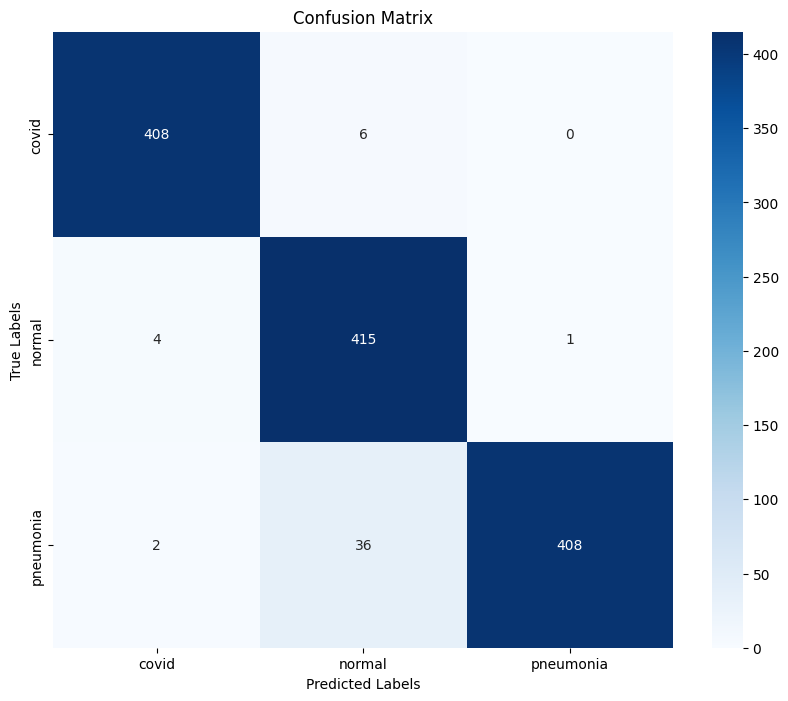

In [22]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()


## Accuracy and Loss Curves

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

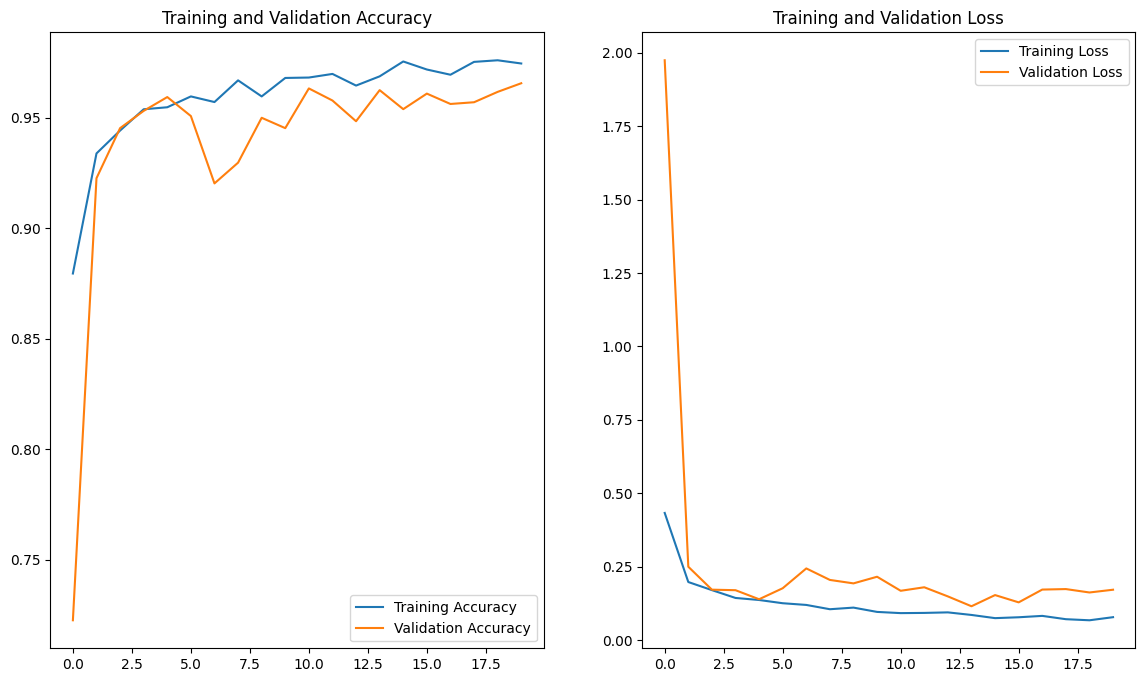

In [24]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('curves.png', dpi = 300)
plt.show()

# Inference



## Inference Function

In [25]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Running Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<Figure size 640x480 with 0 Axes>

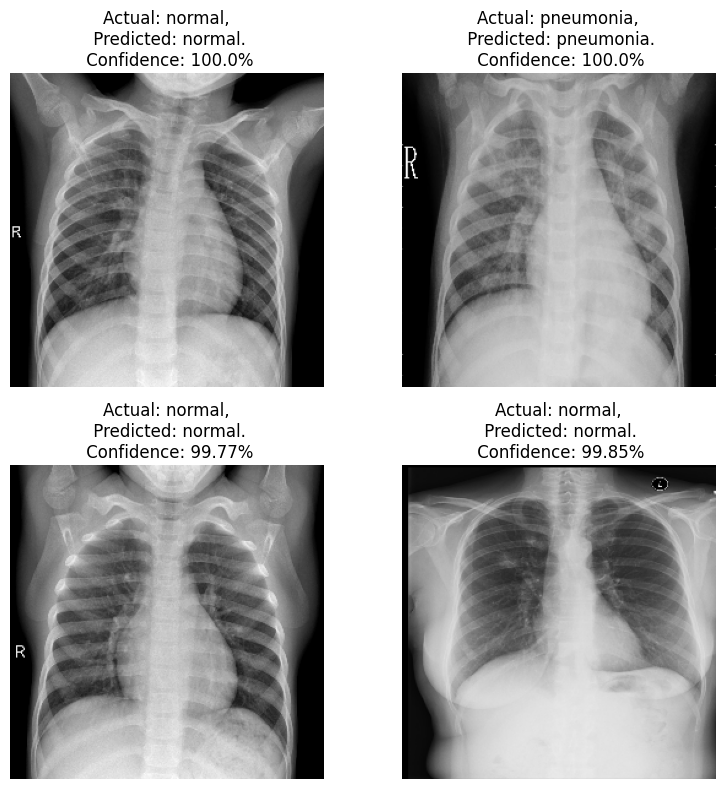

In [26]:
plt.clf()
plt.figure(figsize=(8, 8))
for images, labels in validation_ds.take(6):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        if i < len(images):
            ax.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i])
            actual_class = class_names[labels[i]]

            ax.set_title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            ax.axis("off")
plt.tight_layout()
plt.show()


# Inference from File

In [27]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_index]
    img = Image.open(image_path)
    plt.imshow(img)
    print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: covid


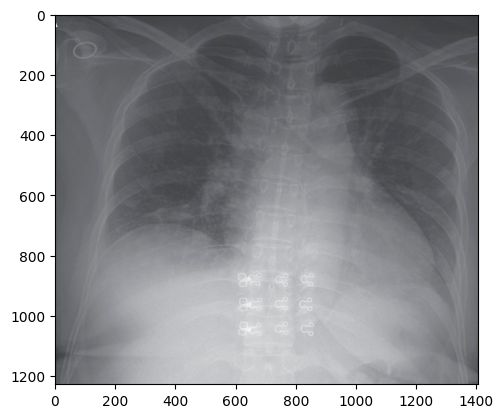

In [28]:
sample_predict(
    model = model,
    image_path = '/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset/covid/005.jpeg'
)